In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ananyahebbar","key":"36fd3782f6e99529dab3b69ac3093ead"}'}

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          10400        315  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           5827        180  0.9705882        
mohamedharris/supermart-grocery-sales-retail-analytics-dataset  Supermart Grocery Sales - Retail Analytics Dataset  191KB  2022-06-12 16:14:44            882         44  0.88235295       
sameepvani/nasa-nearest-earth-objects                       

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip chest-xray-pneumonia

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, ZeroPadding2D, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
inputdir = '/content/chest_xray'
path_train = inputdir + '/train'
path_test = inputdir + '/test'
path_val = inputdir + '/val'
train_normal = os.path.join(path_train + '/NORMAL')
train_pneumonia = os.path.join(path_train + '/PNEUMONIA')
test_normal = os.path.join(path_test + '/NORMAL')
test_pneumonia = os.path.join(path_test + '/PNEUMONIA')
val_normal = os.path.join(path_val + '/NORMAL')
val_pneumonia = os.path.join(path_val + '/PNEUMONIA')
print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ",len(os.listdir(test_pneumonia)))
print("Total number of normal images in val set: ", len(os.listdir(val_normal)))
print("Total number of pnuemonic images in val set: ", len(os.listdir(val_pneumonia)))

Total number of normal images in training set:  1341
Total number of pneumonic images in training set:  3875
Total number of normal images in test set:  234
Total number of pneumonic images in test set:  390
Total number of normal images in val set:  8
Total number of pnuemonic images in val set:  8


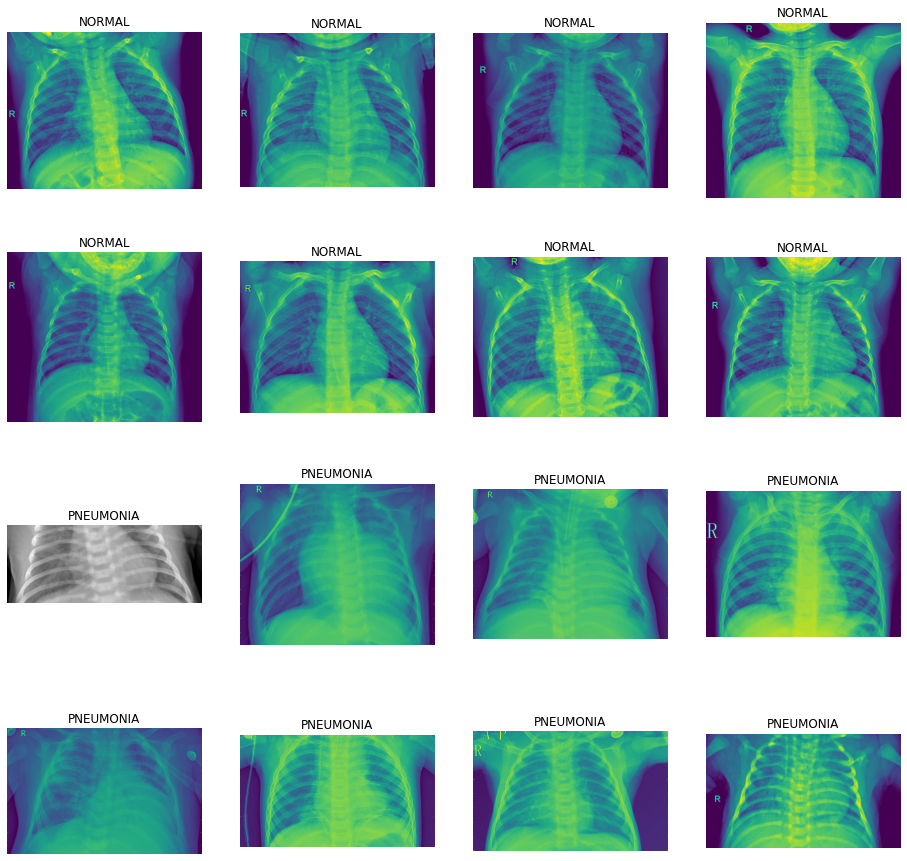

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
next_normal_pix = [os.path.join(train_normal, fname) for fname in os.listdir(train_normal)[0:8]]
next_pneumonia_pix = [os.path.join(train_pneumonia, fname) for fname in os.listdir(train_pneumonia)[0:8]]
for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    if i<=7 :
        sp.title.set_text('NORMAL')
    else :
        sp.title.set_text('PNEUMONIA')
    plt.imshow(img)
plt.show()

In [ ]:
def data_processing(img_size, batch_size):
    
    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       zoom_range = 0.3, 
                                       vertical_flip = True, 
                                       width_shift_range = 0.1, 
                                       height_shift_range = 0.1)
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_set = train_datagen.flow_from_directory(
        path_train, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)
    
    val_set = val_datagen.flow_from_directory(
        path_val, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    test_data = []
    test_labels = []
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path_test + cond)):
            img = plt.imread(path_test + cond + img)
            img = cv2.resize(img, (img_size, img_size))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_set, val_set, test_data, test_labels

In [ ]:
img_size = 150
batch_size = 32
train_set, val_set, test_data, test_labels = data_processing(img_size, batch_size)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = train_set.image_shape, activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))


model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.7))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 separable_conv2d_8 (Separab  (None, 75, 75, 32)       688       
 leConv2D)                                                       
                                                                 
 separable_conv2d_9 (Separab  (None, 75, 75, 32)       1344      
 leConv2D)                                                       
                                                      

In [ ]:
model.compile(optimizer = Adam(lr = 0.001, decay = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint = ModelCheckpoint(filepath = 'trained_pneumonia_model.h5', save_best_only = True, save_weights_only = False)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 2, mode = 'max')

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))

weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

In [ ]:
model_training = model.fit_generator(train_set, 
                              steps_per_epoch = train_set.samples // batch_size, 
                              epochs = 20, 
                              validation_data = val_set,  
                              callbacks = [checkpoint, lr_reduce], 
                              class_weight = class_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
163/163 [==============================] - 287s 2s/step - loss: 0.3902 - accuracy: 0.8278 - val_loss: 1.2785 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 279s 2s/step - loss: 0.3452 - accuracy: 0.8480 - val_loss: 1.1133 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 277s 2s/step - loss: 0.3096 - accuracy: 0.8719 - val_loss: 2.0812 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 279s 2s/step - loss: 0.2796 - accuracy: 0.8873 - val_loss: 2.6456 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
163/163 [==============================] - 279s 2s/step - loss: 0.2773 - accuracy: 0.8831 - val_loss: 0.8124 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/20
163/163 [==============================] - 277s 2s/step - loss: 0.2762 - accuracy: 0.8852 - val_loss: 2.7131 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/20
163/163 [==============================] - 275s 2s/st

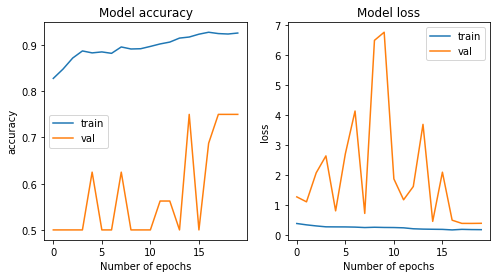

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax = ax.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model_training.history[metric])
    ax[i].plot(model_training.history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('Number of epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Text(0.5, 1.0, 'Confusion Matrix')

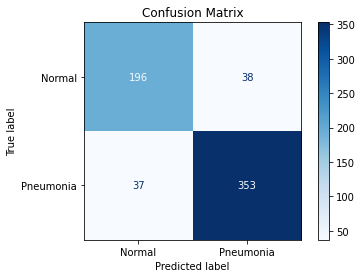

In [ ]:
predictions = model.predict(test_data)
accuracy = accuracy_score(test_labels, np.round(predictions))*100
cm = confusion_matrix(test_labels, np.round(predictions))

cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')

In [ ]:
tn, fp, fn, tp = cm.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

Test Metrics:
Accuracy: 87.98076923076923%
Precision: 90.28132992327366%
Recall: 90.51282051282051%
F1-score: 90.39692701664532


In [ ]:
from sklearn.metrics import classification_report

predictions = np.round(model.predict(test_data))
print(classification_report(test_labels, predictions, target_names = ['Normal (Class 0)','Pnuemonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.84      0.84      0.84       234
Pnuemonia (Class 1)       0.90      0.91      0.90       390

           accuracy                           0.88       624
          macro avg       0.87      0.87      0.87       624
       weighted avg       0.88      0.88      0.88       624

